In [1]:
from db_connection import DB_Connection
import pandas as pd, numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import TextBox
import re, json
from wordcloud import WordCloud
import Tweet


db = DB_Connection()

database = db.query('''SELECT * FROM TWTTWEET WHERE TWEET_CREATED<'2021-01-01'
                    ORDER BY TWEET_CREATED DESC;''')
df = pd.DataFrame(database, columns=['id','userid','text','date',
                            'link','media1','media2','media3', 'media4'])
df = df.loc[:, ['id', 'text']]


processed = Tweet.clean_text(df, 'text')
classified = Tweet.classify_text(processed, 'clean')

# incidents = classified[['id','isIncident']].groupby('isIncident').size()
# accidents = classified[['id','isAccident']].groupby('isAccident').size()[1]
# dangers = classified[['id','isDanger']].groupby('isDanger').size()[1]
# obstacles = classified[['id','isObstacle']].groupby('isObstacle').size()[1]

Connection succesful.


In [23]:
joined = ' '.join([t for t in classified.clean])
joined = joined.split()
new_joined = pd.Series(joined)

In [24]:
len(new_joined.unique())

33733

In [ ]:
x = [0,1,2]
data = [accidents,obstacles,dangers]
plt.figure(figsize=(10,6))
g = sns.barplot(x=x, y=data)
plt.title('% de incidentes por categoría', fontsize=16)
plt.xticks(ticks=x,
        labels=['accidentes','obstáculos','peligros'],
        fontsize=13)
plt.ylim(top=65000)

for i, v in enumerate(data):
    g.text(i, v+1000, v, color='black', ha="center", fontsize=12)
    # plt.annotate(v, (i+3, 10), color='black', fontsize=12)
plt.show()

## Text classification

In [2]:
from sklearn.svm import LinearSVC
import pickle
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
classified.head(1)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(max_features=600, min_df=5, max_df=0.7)
X11 = vectorizer1.fit_transform(classified.clean).toarray()

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X2 = tfidf.fit_transform(X1)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfi = TfidfVectorizer(sublinear_tf=True, max_features=500, min_df=5, max_df=0.7, encoding='utf-8', ngram_range=(1,2))
X3 = tfi.fit_transform(classified.clean).toarray()
# labels = classified.isIncident

In [4]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X11, classified.isIncident, test_size=0.2, random_state=0)

### Random Forest

In [ ]:
start = time.time()
ranfor = RandomForestClassifier(n_estimators=512, random_state=0)
ranfor.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_pred = ranfor.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

In [ ]:
rf_con = confusion_matrix(y_test,y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                rf_con.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     rf_con.flatten()/np.sum(rf_con)]
labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8,4))
sns.heatmap(rf_con/np.sum(rf_con), annot=labels, fmt='', cmap='Blues')
plt.title('Matriz de confusión para Random Forest', fontsize=14)
plt.show()

In [ ]:
with open('ranfor_classifier', 'wb') as picklefile:
    pickle.dump(ranfor, picklefile)

In [ ]:
# load model
with open('ranfor_classifier', 'rb') as training_model:
    ranfor = pickle.load(training_model)

In [ ]:
resume = []
for i in [16,32,64]:#,128,256,512,1024,2048,4096,8192]:
    print('\nPrediction with:', str(i))
    start = time.time()
    ranfor = RandomForestClassifier(n_estimators=i, random_state=0)
    ranfor.fit(X_train, y_train)
    end = time.time()
    y_pred = ranfor.predict(X_test)
    print(str(end-start), accuracy_score(y_test, y_pred))
    resume.append([i, end-start, accuracy_score(y_test, y_pred),
        confusion_matrix(y_test,y_pred), classification_report(y_test,y_pred)])

In [ ]:
for i in [128,256,512,1024,2048,4096,8192]:
    print('\nPrediction with:', str(i))
    start = time.time()
    ranfor = RandomForestClassifier(n_estimators=i, random_state=0)
    ranfor.fit(X_train, y_train)
    end = time.time()
    y_pred = ranfor.predict(X_test)
    print(str(end-start), accuracy_score(y_test, y_pred))
    resume.append([i, end-start, accuracy_score(y_test, y_pred),
        confusion_matrix(y_test,y_pred), classification_report(y_test,y_pred)])

In [ ]:
xs = [i[0] for i in resume]
ys = [i[1] for i in resume]
zs = [i[2] for i in resume]

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
# sns.lineplot(x=range(len(xs)), y=ys, markers=True, style='event')
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.show()

### Boosting Model

In [3]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn import metrics
import xgboost as xgb
import time

In [ ]:
from xgboost import XGBClassifier

start = time.time()
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_xgb = xgb.predict(X_test)

print(confusion_matrix(y_test,y_xgb))
print(classification_report(y_test,y_xgb))
print(accuracy_score(y_test, y_xgb))

In [ ]:
xgresume = []

for i in [64,128,256,512,1024,2048,4096]:
    print('\nestimators:', str(i))
    start = time.time()
    xgb = XGBClassifier(n_estimators=i, learning_rate=0.3, eval_metric='error') # learning_rate
    xgb.fit(X_train, y_train)
    end = time.time()
    y_xgb = xgb.predict(X_test)
    print(str(end-start), accuracy_score(y_test, y_xgb))
    xgresume.append([i, end-start, accuracy_score(y_test, y_xgb),
    confusion_matrix(y_test,y_xgb), classification_report(y_test,y_xgb)])

In [ ]:
xs = [i[0] for i in xgresume]
ys = [i[2] for i in xgresume]
zs = [i[3] for i in xgresume]

plt.figure(figsize=(11,4))
plt.title('XGBoost')
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
# sns.lineplot(x=range(len(xs)), y=ys, markers=True, style='event')
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.show()

In [8]:
param_test0 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

start = time.time()
gsearch0 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=10, max_depth=6,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test0, scoring='accuracy',n_jobs=4, cv=3, verbose=2)
gsearch0.fit(X_train1, y_train1)
end = time.time()
print(str(end-start))
gsearch0.best_params_, gsearch0.best_score_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[14:13:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
305.0426411628723


({'max_depth': 9, 'min_child_weight': 5}, 0.9687940837002523)

In [10]:
param_test1 = {
 'gamma':[i/10.0 for i in range(0,4)]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=9,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='accuracy',n_jobs=4, cv=3, verbose=3)
gsearch1.fit(X_train1, y_train1)
gsearch1.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[14:36:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'gamma': 0.1}, 0.9812265777511792)

In [ ]:
param_test2 = {
 'subsample':[i/10.0 for i in range(6,11)],
 'colsample_bytree':[i/10.0 for i in range(6,11)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=9,
                                        min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test2, scoring='accuracy',n_jobs=4, cv=3, verbose=3)
gsearch2.fit(X_train1, y_train1)
gsearch2.best_params_, gsearch2.best_score_

In [13]:
param_test4 = {
 'subsample':[i/10.0 for i in range(8,11)],
 'colsample_bytree':[i/10.0 for i in range(8,11)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=9,
                                        min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test4, scoring='accuracy',n_jobs=4, cv=3, verbose=1)
gsearch4.fit(X_train1, y_train1)
gsearch4.best_params_, gsearch4.best_score_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[15:16:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.9812265777511792)

In [16]:
param_test3 = {
 'reg_alpha':[0, 1e-5, 0.001, 0.005, 0.01, 0.05, 0.1]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.3, n_estimators=100, max_depth=9,
                                        min_child_weight=1, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test3, scoring='accuracy',n_jobs=4, cv=3, verbose=3)
gsearch3.fit(X_train1, y_train1)
gsearch3.best_params_, gsearch3.best_score_

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[15:51:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'reg_alpha': 0.005}, 0.9812622009433021)

In [17]:
grid_results3 = pd.DataFrame(gsearch3.cv_results_)
grid_results3.sort_values('rank_test_score').head(5)#[['rank_test_score','param_colsample_bytree', 'param_subsample', 'mean_test_score', 'std_test_score']].rename(columns={'param_colsample_bytree':'colsample_bytree', 'param_param_subsample':'subsample'})

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,348.778189,0.535878,1.363131,0.100375,0.005,{'reg_alpha': 0.005},0.980699,0.981405,0.981683,0.981262,0.000414,1
0,219.511019,0.811760,0.874954,0.103564,0,{'reg_alpha': 0},0.980849,0.981276,0.981554,0.981227,0.000290,2
1,275.177919,38.832992,1.351461,0.395938,0.00001,{'reg_alpha': 1e-05},0.980849,0.981276,0.981554,0.981227,0.000290,2
4,349.402620,2.280570,1.390038,0.048816,0.01,{'reg_alpha': 0.01},0.980742,0.981341,0.981512,0.981198,0.000330,4
2,319.733945,20.624303,1.429999,0.110721,0.001,{'reg_alpha': 0.001},0.980742,0.981276,0.981554,0.981191,0.000337,5


In [18]:
grid_results3.to_csv('grid_search_results3-4.csv')

In [ ]:
xgb1 = XGBClassifier(
    learning_rate=0.3,
    n_estimators=2000,
    max_depth=9, min_child_weight=1,
    gamma=0.1, subsample=0.9, colsample_bytree=1,
    nthread=4, seed=27, verbosity=3)

xgb_param = xgb1.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=5,
    early_stopping_rounds=50)
xgb1.set_params(n_estimators=cvresult.shape[0])

In [ ]:
#Fit the algorithm on the data
print('Start training.')
start = time.time()
xgb1.fit(X_train, y_train, verbose=True)
print('End training.') 
end = time.time()
    
#Predict training set:
dtrain_predictions = xgb1.predict(X_test)
dtrain_predprob = xgb1.predict_proba(X_test)[:,1]
    
#Print model report:
print("\nModel Report")
print("Duration:", str(end-start))
print("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtrain_predictions))
print("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtrain_predprob))
                
plt.figure(figsize=(15,5))
feat_imp = pd.Series(xgb1.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### Estimators adjust

In [20]:
xgresume = []
xgb_arr = []

for i in [512,1024,2048]:
    print('\nestimators:', str(i))
    start = time.time()
    xgb = XGBClassifier(
        learning_rate=0.3,
        n_estimators=i,
        max_depth=9, min_child_weight=1,
        gamma=0.1, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.005,
        nthread=4, seed=27, eval_metric='error', verbosity=0)
    xgb_arr.append(xgb)
    print('Fitting... ', time.asctime())
    xgb_arr[-1].fit(X_train1, y_train1)
    end = time.time()
    print('Predicting... ', time.asctime())
    y_xgb = xgb_arr[-1].predict(X_test1)
    print(str(end-start), accuracy_score(y_test1, y_xgb))
    xgresume.append([i, end-start, accuracy_score(y_test1, y_xgb),
    confusion_matrix(y_test1,y_xgb), classification_report(y_test1,y_xgb)])


estimators: 512
Fitting...  Thu Feb 18 16:02:16 2021
Predicting...  Thu Feb 18 16:12:24 2021
608.3386294841766 0.9828441151325163

estimators: 1024
Fitting...  Thu Feb 18 16:12:25 2021
Predicting...  Thu Feb 18 16:40:20 2021
1675.0280911922455 0.9831290966087204

estimators: 2048
Fitting...  Thu Feb 18 16:40:21 2021
Predicting...  Thu Feb 18 17:36:28 2021
3366.2757561206818 0.9827016243944143


In [21]:
for i in xgresume:
    for s in i: print(s)
    print('\n')

512
608.3386294841766
0.9828441151325163
[[18547    81]
 [  521 15941]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18628
           1       0.99      0.97      0.98     16462

    accuracy                           0.98     35090
   macro avg       0.98      0.98      0.98     35090
weighted avg       0.98      0.98      0.98     35090



1024
1675.0280911922455
0.9831290966087204
[[18532    96]
 [  496 15966]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18628
           1       0.99      0.97      0.98     16462

    accuracy                           0.98     35090
   macro avg       0.98      0.98      0.98     35090
weighted avg       0.98      0.98      0.98     35090



2048
3366.2757561206818
0.9827016243944143
[[18501   127]
 [  480 15982]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18628
           1 

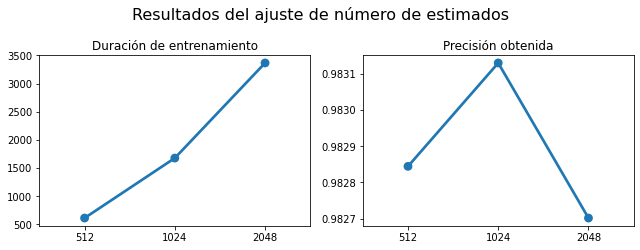

In [72]:
xs = [i[0] for i in xgresume]
ys = [i[1] for i in xgresume]
zs = [i[2] for i in xgresume]

plt.figure(figsize=(9,3.5))
plt.suptitle('Resultados del ajuste de número de estimados', fontsize=16)
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.tight_layout()
plt.show()

In [91]:
with open('xgbresume0', 'wb') as picklefile:
    pickle.dump(xgresume, picklefile)
with open('xgbarr0', 'wb') as picklefile:
    pickle.dump(xgb_arr, picklefile)

In [23]:
xgresume1 = []
xgb_arr1 = []

for i in [600,700,800,900]:
    print('\nestimators:', str(i))
    start = time.time()
    xgb = XGBClassifier(
        learning_rate=0.3,
        n_estimators=i,
        max_depth=9, min_child_weight=1,
        gamma=0.1, subsample=0.8, colsample_bytree=0.8,
        reg_alpha=0.005,
        nthread=4, seed=27, eval_metric='error', verbosity=0)
    xgb_arr1.append(xgb)
    xgb_arr1[-1].fit(X_train1, y_train1)
    end = time.time()
    y_xgb = xgb_arr1[-1].predict(X_test1)
    print(str(end-start), accuracy_score(y_test1, y_xgb))
    xgresume1.append([i, end-start, accuracy_score(y_test1, y_xgb),
    confusion_matrix(y_test1,y_xgb), classification_report(y_test1,y_xgb)])


estimators: 600
843.4114825725555 0.982958107722998

estimators: 700
1159.8502888679504 0.9829866058706184

estimators: 800
1267.0512402057648 0.9830151040182388

estimators: 900
1491.8558073043823 0.9831290966087204


In [27]:
for i in xgresume1:
    for s in i: print(s)
    print('\n')

600
843.4114825725555
0.982958107722998
[[18542    86]
 [  512 15950]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18628
           1       0.99      0.97      0.98     16462

    accuracy                           0.98     35090
   macro avg       0.98      0.98      0.98     35090
weighted avg       0.98      0.98      0.98     35090



700
1159.8502888679504
0.9829866058706184
[[18536    92]
 [  505 15957]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18628
           1       0.99      0.97      0.98     16462

    accuracy                           0.98     35090
   macro avg       0.98      0.98      0.98     35090
weighted avg       0.98      0.98      0.98     35090



800
1267.0512402057648
0.9830151040182388
[[18533    95]
 [  501 15961]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18628
           1    

In [85]:
[i[0] for i in xgresume1] + [xgresume[1][0]]

[600, 700, 800, 900, 1024]

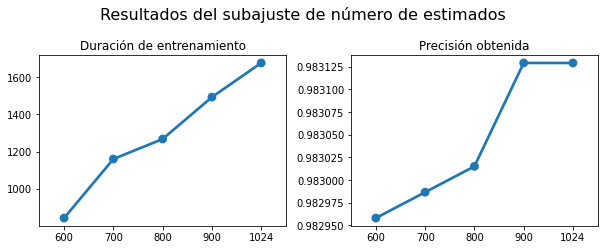

In [87]:
xs = [i[0] for i in xgresume1] + [xgresume[1][0]]
ys = [i[1] for i in xgresume1] + [xgresume[1][1]]
zs = [i[2] for i in xgresume1] + [xgresume[1][2]]

plt.figure(figsize=(8.5,3.5))
plt.suptitle('Resultados del subajuste de número de estimados', fontsize=16)
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.tight_layout()
plt.show()

In [92]:
with open('xgbresume1', 'wb') as picklefile:
    pickle.dump(xgresume1, picklefile)
with open('xgbarr1', 'wb') as picklefile:
    pickle.dump(xgb_arr1, picklefile)

In [8]:
print('\nestimators: 1000')
start = time.time()
xgb_final = XGBClassifier(
    learning_rate=0.3,
    n_estimators=1000,
    max_depth=9, min_child_weight=1,
    gamma=0.1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005,
    nthread=4, seed=27, eval_metric='error', verbosity=0)
xgb_final.fit(X_train, y_train)
end = time.time()
y_xgb = xgb_final.predict(X_test)
print(str(end-start), accuracy_score(y_test, y_xgb))


estimators: 700
1089.302880525589 0.9828726132801368


In [77]:
xgb_final = xgb_arr1[-1]
y_xgb = xgb_final.predict(X_test1)
xgb_final

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='error',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=900, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=27, reg_alpha=0.005,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=0)

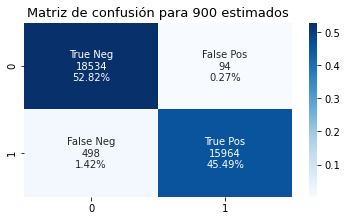

In [82]:
xgb_con = confusion_matrix(y_test1,y_xgb)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                xgb_con.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     xgb_con.flatten()/np.sum(xgb_con)]
labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(6,3.2))
sns.heatmap(xgb_con/np.sum(xgb_con), annot=labels, fmt='', cmap='Blues')
plt.title('Matriz de confusión para 900 estimados', fontsize=13)
plt.show()

In [25]:
with open('xgb_classifier', 'wb') as picklefile:
    pickle.dump(xgb_final, picklefile)

#### Count vectors adjust

In [29]:
# load model
with open('xgb_classifier', 'rb') as training_model:
    xgb = pickle.load(training_model)

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

xgresume2 = []
xgb_arr2 = []

for i in [800, 1000, 2000, 5000, 10000]:
    print('\nnumber of features:', str(i))
    vectorizer = CountVectorizer(max_features=i, min_df=5, max_df=0.7)
    print('Fitting vectorizer...')
    X1 = vectorizer.fit_transform(classified.clean).toarray()
    print('Creating train-test data...')
    X_train, X_test, y_train, y_test = train_test_split(X1, classified.isIncident, test_size=0.2, random_state=0)
    print('Fitting model...', time.asctime())
    with open('xgb_classifier', 'rb') as training_model:
        xgb_arr2.append(pickle.load(training_model))
    start = time.time()
    xgb_arr2[-1].fit(X_train,y_train)
    end = time.time()
    print('Fitting time:', str(end-start), '\nPredicting...')
    y_xgb = xgb_arr2[-1].predict(X_test)
    print(accuracy_score(y_test, y_xgb))
    print(confusion_matrix(y_test,y_xgb))
    print(classification_report(y_test,y_xgb))
    xgresume2.append([i, end-start, accuracy_score(y_test, y_xgb),
    confusion_matrix(y_test,y_xgb), classification_report(y_test,y_xgb)])


number of features: 800
Fitting vectorizer...
Creating train-test data...
Fitting model... Thu Feb 18 19:27:25 2021
Fitting time: 1667.7572576999664 
Predicting...
0.9895696779709319
[[18581    47]
 [  319 16143]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18628
           1       1.00      0.98      0.99     16462

    accuracy                           0.99     35090
   macro avg       0.99      0.99      0.99     35090
weighted avg       0.99      0.99      0.99     35090


number of features: 1000
Fitting vectorizer...
Creating train-test data...
Fitting model... Thu Feb 18 19:55:17 2021
Fitting time: 2260.348706007004 
Predicting...
0.9898831575947563
[[18565    63]
 [  292 16170]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18628
           1       1.00      0.98      0.99     16462

    accuracy                           0.99     35090
   macro avg       0.99  

XGBoostError: bad allocation

In [93]:
with open('xgbresume2', 'wb') as picklefile:
    pickle.dump(xgresume2, picklefile)
with open('xgbarr2', 'wb') as picklefile:
    pickle.dump(xgb_arr2, picklefile)

In [5]:
# load model
with open('./others/resumes/xgbarr2', 'rb') as arr:
    xgb_arr2 = pickle.load(arr)
with open('./others/resumes/xgbresume2', 'rb') as resume:
    xgresume2 = pickle.load(resume)

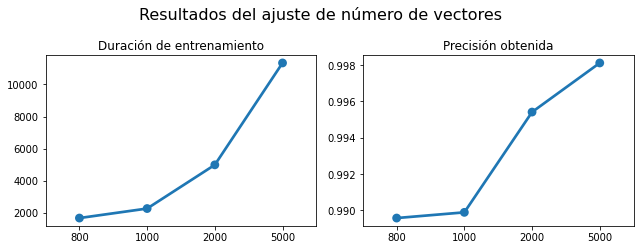

In [6]:
xs = [i[0] for i in xgresume2]
ys = [i[1] for i in xgresume2]
zs = [i[2] for i in xgresume2]

plt.figure(figsize=(9,3.5))
plt.suptitle('Resultados del ajuste de número de vectores', fontsize=16)
plt.subplot(1, 2, 1)
sns.pointplot(x=xs, y=ys)
plt.title('Duración de entrenamiento')
plt.xticks(range(len(xs)), xs)
plt.subplot(1, 2, 2)
sns.pointplot(x=xs, y=zs)
plt.title('Precisión obtenida')
plt.xticks(range(len(xs)), xs)
plt.tight_layout()
plt.show()

In [52]:
# save final xgb model
xgb_final2 = xgb_arr2[-1]

In [17]:
# fit vectorizer 5000 features
i = 5000
print('\nnumber of features:', str(i))
vectorizer10 = CountVectorizer(max_features=i, min_df=5, max_df=0.7)
print('Fitting vectorizer...', time.asctime())
vectorizer10.fit(classified.clean)


number of features: 5000
Fitting vectorizer... Fri Feb 19 13:58:13 2021
Creating train-test data...


In [5]:
# convert and split data
X_vect = vect.transform(classified.clean).toarray()
print('Creating train-test data...')
X_train, X_test, y_train, y_test = train_test_split(X_vect, classified.isIncident, test_size=0.2, random_state=0)
print('Done.')

Creating train-test data...


In [18]:
with open('vectorizer5000', 'wb') as picklefile:
    pickle.dump(vectorizer10, picklefile)

In [4]:
# load model fo 5000 features
with open('count_vectorizer', 'rb') as v:
    vect = pickle.load(v)

In [6]:
#load model
with open('xgb_5000', 'rb') as training_model:
    xgb_classifier = pickle.load(training_model)

In [ ]:
# fit classifier with 5000 features
print('Fitting model...', time.asctime())
start = time.time()
xgb_classifier.fit(X_train,y_train)
end = time.time()
print('Fitting time:', str(end-start), '\nPredicting...')

In [7]:
# predict test data
print('Predicting data...')
y_xgb2 = xgb_classifier.predict(X_test)
print(accuracy_score(y_test, y_xgb2))
print(confusion_matrix(y_test,y_xgb2))
print(classification_report(y_test,y_xgb2))
# xgresume2.append([i, end-start, accuracy_score(y_test, y_xgb2),
# confusion_matrix(y_test,y_xgb2), classification_report(y_test,y_xgb2)])

0.9981191222570532
[[18618     7]
 [   59 16406]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18625
           1       1.00      1.00      1.00     16465

    accuracy                           1.00     35090
   macro avg       1.00      1.00      1.00     35090
weighted avg       1.00      1.00      1.00     35090



In [ ]:
# save trained classifier
with open('xgb_features_final', 'wb') as picklefile:
    pickle.dump(xgb_classifier, picklefile)

In [29]:
# count vectors for 10000
i = 10000
print('\nnumber of features:', str(i))
vectorizer100 = CountVectorizer(max_features=i, min_df=5, max_df=0.7)
print('Fitting vectorizer...', time.asctime())
vectorizer100.fit(classified.clean)
X_vect1 = vectorizer100.transform(classified.clean).toarray()
print('Creating train-test data...')
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_vect1, classified.isIncident, test_size=0.2, random_state=0)
with open('vectorizer10000', 'wb') as picklefile:
    pickle.dump(vectorizer100, picklefile)


number of features: 10000
Fitting vectorizer... Fri Feb 19 16:16:47 2021
Creating train-test data...


In [ ]:
# fitting 10000 vectors
#load model
with open('xgb_classifier', 'rb') as model:
    xgb_classifier1 = pickle.load(model)
print('Fitting model...', time.asctime())
start = time.time()
xgb_classifier1.fit(X_train3,y_train3)
end = time.time()
print('Fitting time:', str(end-start), '\nPredicting...')
y_xgb3 = xgb_classifier1.predict(X_test3)
print(accuracy_score(y_test3, y_xgb3))
print(confusion_matrix(y_test3,y_xgb3))
print(classification_report(y_test3,y_xgb3))
# xgresume2.append([i, end-start, accuracy_score(y_test, y_xgb3),
# confusion_matrix(y_test,y_xgb3), classification_report(y_test,y_xgb3)])

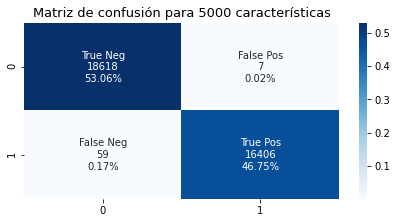

In [8]:
xgb_con = confusion_matrix(y_test,y_xgb2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                xgb_con.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     xgb_con.flatten()/np.sum(xgb_con)]
labels = ['%s\n%s\n%s' % (v1, v2, v3) for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(6,3.2))
sns.heatmap(xgb_con/np.sum(xgb_con), annot=labels, fmt='', cmap='Blues')
plt.title('Matriz de confusión para 5000 características', fontsize=13)
plt.tight_layout()
plt.show()

Text(0.5, 0, '')

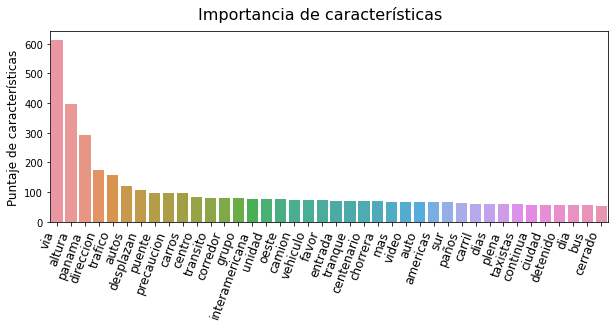

In [28]:
feat_df = pd.DataFrame(X_vect)
feat_df.columns = vect.get_feature_names()

plt.figure(figsize=(10,3.5))
feat_imp = pd.Series(xgb_classifier.get_booster().get_fscore()).sort_values(ascending=False)[:40]
# feat_imp.plot(kind='bar', title='Feature] Importances')
feat_values = [int(re.sub('f', '', i)) for i in feat_imp.index]
feat_names = [feat_df.columns[i] for i in feat_values]
features = pd.DataFrame({'feature_num':feat_values, 'names':feat_names, 'count':feat_imp.values})
# plt.bar(x=feat_values, height=feat_imp.values)
# sns.barplot(x=feat_values, y=feat_imp.values, data=feat_imp, order=feat_imp.values)
plt.suptitle('Importancia de características', fontsize=16)
# plt.subplot(2, 1, 1)
sns.barplot(x='names', y='count', data=features)
plt.xticks(rotation=70, fontsize=12, ha='right')
plt.ylabel('Puntaje de características', fontsize=12)
# plt.tight_layout()
plt.xlabel(None)

### SVM

In [ ]:
start = time.time()
svc = LinearSVC()
svc.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_svc = svc.predict(X_test)

print(confusion_matrix(y_test,y_svc))
print(classification_report(y_test,y_svc))
print(accuracy_score(y_test, y_svc))

In [ ]:
with open('svc_classifier', 'wb') as picklefile:
    pickle.dump(svc, picklefile)

In [ ]:
# load model
with open('ranfor_classifier', 'rb') as training_model:
    ranfor = pickle.load(training_model)

### Naive-Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

start = time.time()
nb = MultinomialNB()
nb.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_nb = nb.predict(X_test)

print(confusion_matrix(y_test,y_nb))
print(classification_report(y_test,y_nb))
print(accuracy_score(y_test, y_nb))

### Gaussian Naive-Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

start = time.time()
gnb = GaussianNB()
gnb.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_gnb = gnb.predict(X_test)

print(confusion_matrix(y_test,y_gnb))
print(classification_report(y_test,y_gnb))
print(accuracy_score(y_test, y_gnb))

### Boosting RF Model

In [ ]:
from xgboost import XGBRFClassifier

start = time.time()
xrfgb = XGBRFClassifier()
xrfgb.fit(X_train, y_train)
end = time.time()
print('Duration:', str(end-start))

y_xrfgb = xrfgb.predict(X_test)

print(confusion_matrix(y_test,y_xrfgb))
print(classification_report(y_test,y_xrfgb))
print(accuracy_score(y_test, y_xrfgb))